In [1]:
import os
import pickle
import logging

import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import HierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH,
    INFERENCE_FILE,
    NETCODE_FILE,
    BUILD_DIR
)

logger = logging.getLogger(__name__)
plt.rcParams["svg.fonttype"] = "none"

setup_logging(dir=BUILD_DIR, fname="figure")

NUM_SAMPLES = 5000


2024-06-06 22:37:13,364 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/figure.log


In [2]:
M = HierarchicalBayesianModel

# Load posterior
dest = os.path.join(BUILD_DIR, M.NAME, INFERENCE_FILE)
with open(dest, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)

posterior_samples = posterior_samples_.copy()
posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Load data
df = pd.read_csv(DATA_PATH)
ind = ~df[model.response].isna().values.any(axis=-1)
df = df[ind].reset_index(drop=True).copy()
df, encoder_dict = model.load(df=df)


2024-06-06 22:37:13,380 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-06-06 22:37:13,381 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-06-06 22:37:13,381 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-06-06 22:37:13,381 - jax._src.xla_bridge - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-06-06 22:37:14,355 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/hierarchical_bayesian_model
2024-06-06 22:37:14,357 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 22:37:14,358 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
encoder_dict[model.features[1]].inverse_transform([0, 1])


array(['L', 'M'], dtype=object)

In [4]:
(posterior_samples["a_delta_loc"] > 0).mean(axis=0)


array([[1.     , 1.     , 0.99975, 0.999  ]])

In [5]:
subset = [(7, 0), (7, 1), (12, 0), (12, 1)]
ind = df[model.features].apply(tuple, axis=1).isin(subset)
df = df[ind].reset_index(drop=True).copy()

prediction_df = model.make_prediction_dataset(df=df, num_points=NUM_SAMPLES)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


2024-06-06 22:37:14,470 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2024-06-06 22:39:30,063 - hbmep.utils.utils - INFO - func:predict took: 2 min and 15.59 sec


In [6]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)

mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)

a_delta_loc = posterior_samples["a_delta_loc"]
a_delta_loc[:, 0, :].shape


(4000, 4)

In [7]:
hdi = az.hdi(a_delta_loc[:, 0, :].reshape(model.mcmc_params["num_chains"], -1, a_delta_loc.shape[-1]), hdi_prob=.95)
hdi


array([[1.37970107, 3.51663985],
       [1.65669568, 3.74186874],
       [1.44235259, 3.64234068],
       [1.14638296, 3.30210781]])

In [8]:
# Plot aesthetics
response_colors = {
    # Lateral (light)
    0: {
        1: (0.6706, 0.8510, 0.9137),
        0: (0.8745, 0.7608, 0.4902),
        2: (0.9451, 0.7137, 0.8549),
        3: (0.7216, 0.8824, 0.5255)
    },
    # Midline (dark)
    1: {
        1: (0.1725, 0.4824, 0.7137),
        0: (0.6510, 0.3804, 0.1020),
        2: (0.8157, 0.1098, 0.5451),
        3: (0.3020, 0.6745, 0.1490)
    }
}
prior_color = (.7, .7, .7)
cmap = sns.color_palette("tab10")
axis_label_size = 10


2024-06-06 22:39:49,760 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/use_cases_within.png


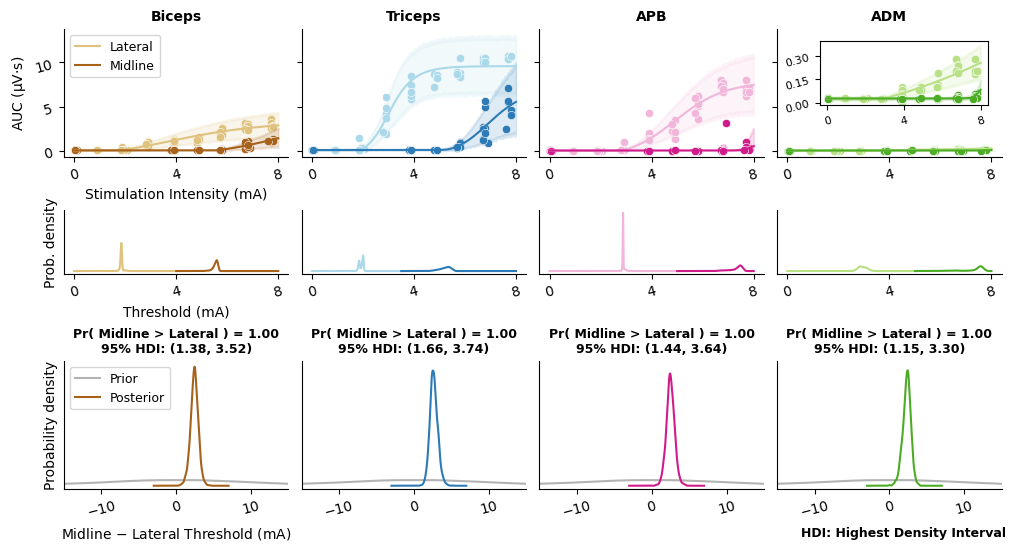

In [9]:
alt_text_size = 9

response = model.response
n_response = model.n_response

# Plot
nrows, ncols = 3, n_response
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(2.5 * ncols, 1.8 * nrows),
    squeeze=False,
    height_ratios=[1, .5, 1],
    constrained_layout=True,
)

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        c = (7, side)
        if side == 0: lab = "Lateral"
        if side == 1: lab = "Midline"
        color = response_colors[side][muscle_ind]

        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[0, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax, label=lab)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 1])

        ax = axes[1, muscle_ind]
        x_grid = temp_pred_df[model.intensity].values
        if side == 0:
            match muscle_ind:
                case 1: x_grid_ind = x_grid < 3.5
                case 0: x_grid_ind = x_grid < 4
                case 2: x_grid_ind = x_grid < 5
                case 3: x_grid_ind = x_grid < 5

        if side == 1:
            match muscle_ind:
                case 1: x_grid_ind = x_grid > 3.5
                case 0: x_grid_ind = x_grid > 4
                case 2: x_grid_ind = x_grid > 5
                case 3: x_grid_ind = x_grid > 5

        x_grid = x_grid[x_grid_ind]
        kde = stats.gaussian_kde(a[:, *c, muscle_ind])
        density = kde(x_grid)
        ax.plot(x_grid, density, color=color)
        ax.sharex(axes[0, 0])
        ax.sharey(axes[1, 2])

    ax = axes[2, muscle_ind]
    samples = a_delta_loc[:, 0, muscle_ind]
    d = dist.Normal(0, 10)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")

    match muscle_ind:
        case 1: x_grid = np.linspace(-3, 7, 5000)
        case 0: x_grid = np.linspace(-3, 7, 5000)
        case 2: x_grid = np.linspace(-3, 7, 5000)
        case 3: x_grid = np.linspace(-3, 7, 5000)
    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=response_colors[1][muscle_ind], label="Posterior")
    prob = (samples > 0).mean()
    ax.set_title(
        f"Pr( Midline > Lateral ) = {prob:.2f}\n95% HDI: ({hdi[muscle_ind, 0]:.2f}, {hdi[muscle_ind, 1]:.2f})",
        fontweight="bold",
        size=alt_text_size
    )
    ax.sharex(axes[2, 0])
    ax.sharey(axes[2, 0])
    ax.set_xlim(left=-15, right=15)
    ax.set_ylim(bottom=-.02)

muscle_ind = 3
ax = axes[0, muscle_ind]
ins = ax.inset_axes([0.19,0.4,0.75 ,0.5])
for side in [0, 1]:
    c = (7, side)
    color = response_colors[side][muscle_ind]

    ind = df[model.features].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True).copy()

    pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
    temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

    temp_obs = obs[:, pred_ind, muscle_ind]
    temp_mu = mu[:, pred_ind, muscle_ind]
    temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
    sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
    ins.fill_between(
        temp_pred_df[model.intensity],
        temp_obs_hpdi[0, :],
        temp_obs_hpdi[1, :],
        color=color,
        alpha=.15
    )
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_xticks([0, 4, 8])
    # ins.set_yticks([0, 0.2])
    ins.yaxis.set_major_locator(plt.MaxNLocator(3))
    ins.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=8
    )

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

ax = axes[0, 0]
ax.set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)
ax.set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 4, 8])
ax.legend(loc="upper left", prop={'size': alt_text_size})

ax = axes[1, 0]
ax.set_xlabel("Threshold (mA)", size=axis_label_size)
ax.set_ylabel("Prob. density", size=axis_label_size)

ax = axes[2, 0]
ax.set_xlabel("Midline $-$ Lateral Threshold (mA)", size=axis_label_size)
ax.set_ylabel("Probability density", size=axis_label_size)
ax.legend(loc="upper left", prop={'size': alt_text_size})

for j in range(1, model.n_response):
    ax = axes[0, j]
    ax.get_legend().remove()

for j in range(model.n_response):
    ax = axes[0, j]
    ax.set_title(response[j], fontweight="bold", size=axis_label_size)
    ax = axes[1, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
    )
    ax = axes[2, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
    )

fig.text(1, 0.01, "HDI: Highest Density Interval", size=alt_text_size, ha="right", va="bottom", fontweight="bold")
# fig.text(0.01, .4, "N = 13\nparticipants", size=alt_text_size - 2, fontweight="bold", rotation=15, ma="center")

fig.align_xlabels()
fig.align_ylabels(axes[0, :])
fig.align_ylabels(axes[1:, :])

dest = os.path.join(BUILD_DIR, "use_cases_within.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "use_cases_within.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
